#  Import Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset 

In [3]:
# Load from the correct project path
file_path = '../data/raw/MTA_Performance_Agencies.csv'  
df = pd.read_csv(file_path, encoding='ISO-8859-1')

#  Convert Date Column 

In [4]:
df['DATE'] = pd.to_datetime(df['YYYY_MM'], format='%Y-%m')

#  Set Plot Style 

In [4]:
sns.set(style="whitegrid")

Check for Missing Values - show missing values per column

In [5]:
df.isnull().sum()

INDICATOR_SEQ     0
PARENT_SEQ        0
AGENCY_NAME       0
INDICATOR_NAME    0
DESCRIPTION       0
CATEGORY          0
FREQUENCY         0
DESIRED_CHANGE    0
INDICATOR_UNIT    0
DECIMAL_PLACES    0
PERIOD_YEAR       0
PERIOD_MONTH      0
YTD_TARGET        0
YTD_ACTUAL        0
MONTHLY_TARGET    0
MONTHLY_ACTUAL    0
YYYY_MM           0
DATE              0
dtype: int64

Check for Duplicate Records and Data


In [6]:
df.duplicated().sum()

np.int64(0)

# DESCRIPTIVE ANALYSIS

In [6]:
# Summary of all numeric variables
pd.set_option('display.float_format', '{:,.2f}'.format)
df[['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']].describe()

,MONTHLY_ACTUAL,MONTHLY_TARGET,YTD_ACTUAL,YTD_TARGET
count,"13,862.00","13,862.00","13,862.00","13,862.00"
mean,"1,989,277.36","1,918,328.12","12,511,243.51","12,470,129.08"
std,"13,669,551.12","13,626,465.24","98,766,870.38","100,134,352.20"
min,0.00,0.00,0.19,0.00
25%,77.80,75.00,77.90,75.00
50%,95.20,95.10,95.20,95.10
75%,99.16,99.36,98.98,99.36
max,"161,124,042.00","159,121,000.00","1,762,491,655.00","1,801,642,000.00"


# Number of Records by Agency

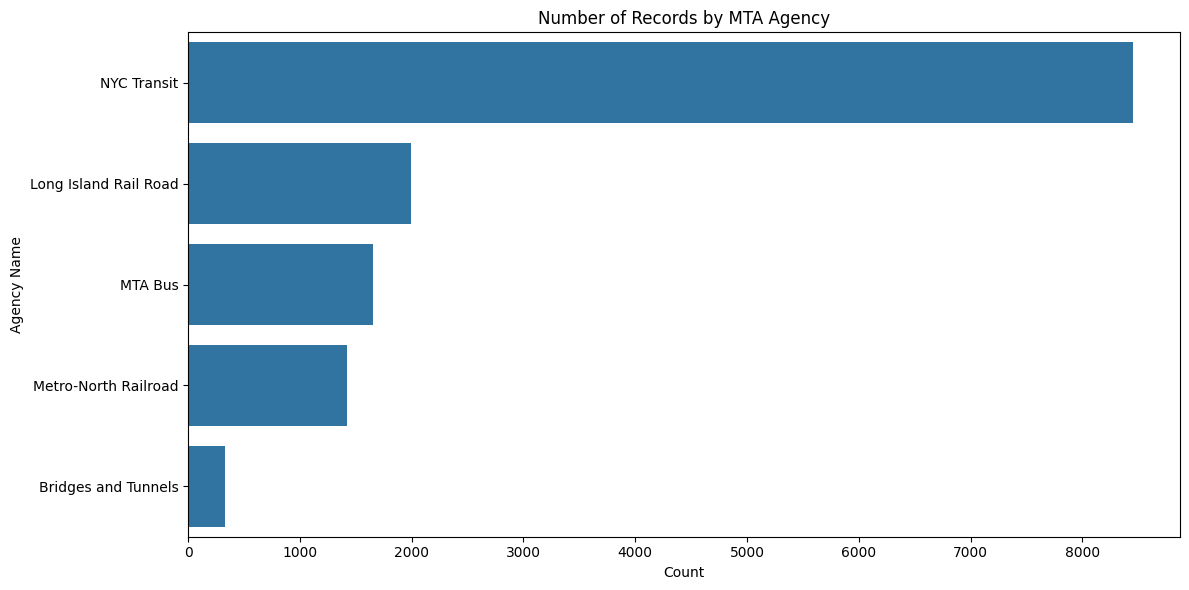

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='AGENCY_NAME', order=df['AGENCY_NAME'].value_counts().index)
plt.title('Number of Records by MTA Agency')
plt.xlabel('Count')
plt.ylabel('Agency Name')
plt.tight_layout()
plt.show()

# Top 15 Most Frequent Performance Indicators

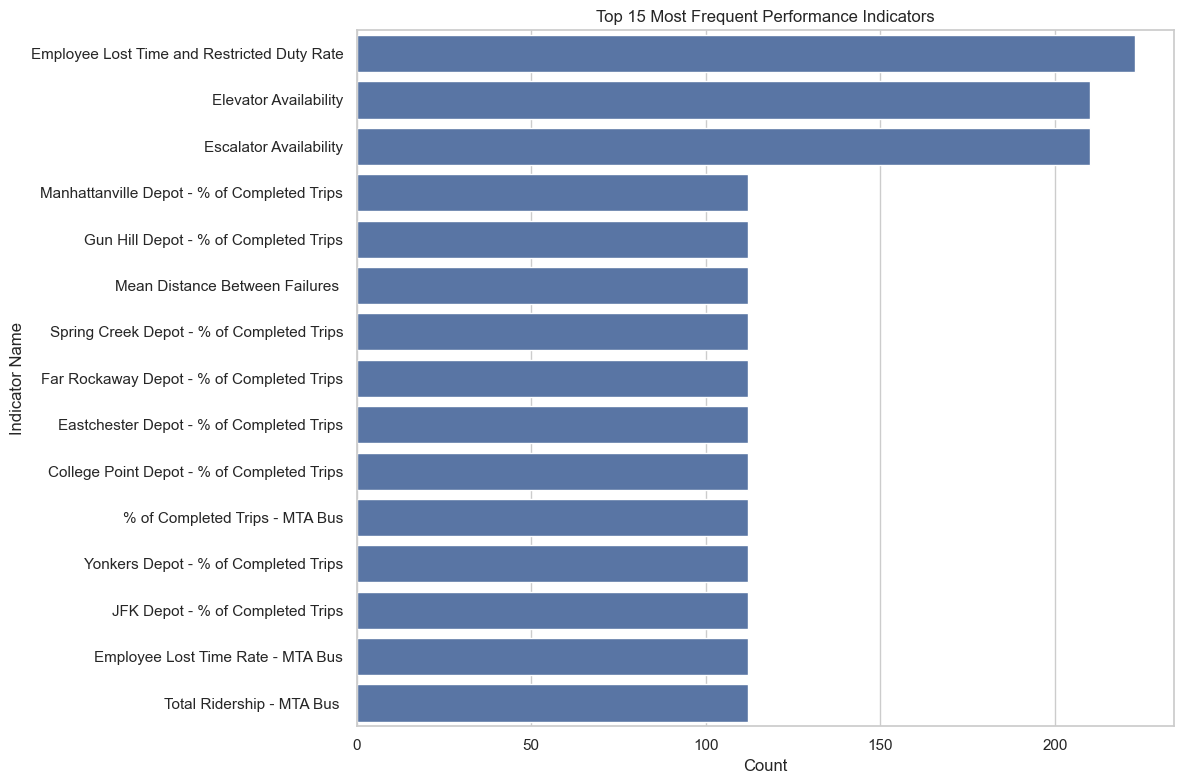

In [9]:
plt.figure(figsize=(12,8))
top_indicators = df['INDICATOR_NAME'].value_counts().nlargest(15).index
sns.countplot(data=df[df['INDICATOR_NAME'].isin(top_indicators)], y='INDICATOR_NAME', order=top_indicators)
plt.title('Top 15 Most Frequent Performance Indicators')
plt.xlabel('Count')
plt.ylabel('Indicator Name')
plt.tight_layout()
plt.show()

# Boxplot -  Comparing distributions across Agencies

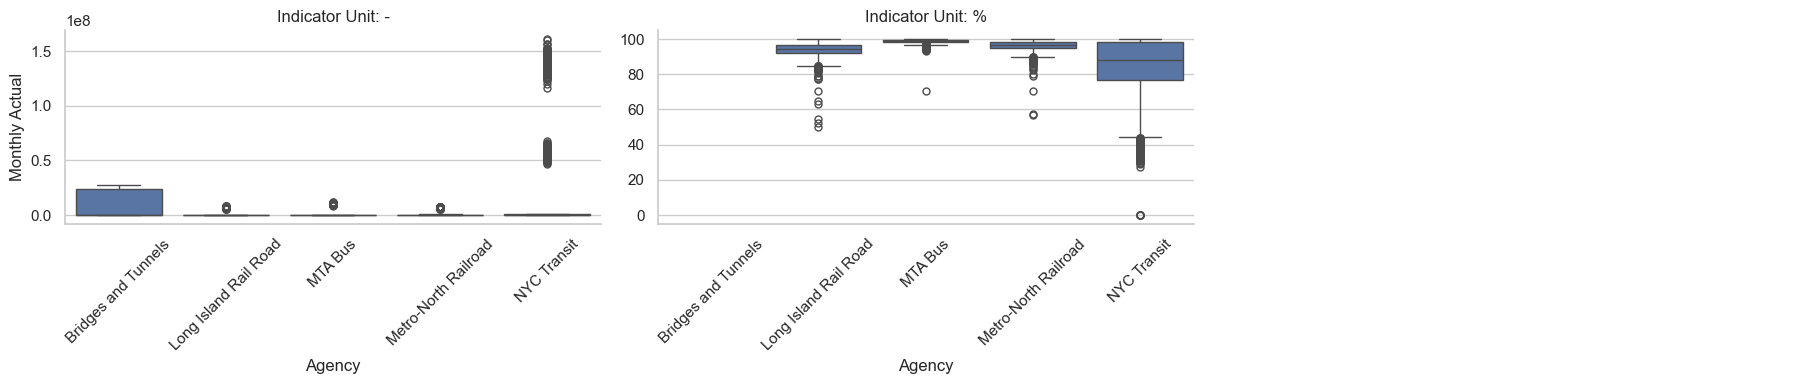

In [10]:
# Clean blank or missing indicator units for readability
df['INDICATOR_UNIT'] = df['INDICATOR_UNIT'].replace('', 'Unspecified')

# Create boxplots split by unit
g = sns.catplot(
    data=df,
    kind="box",
    x="AGENCY_NAME",
    y="MONTHLY_ACTUAL",
    col="INDICATOR_UNIT",
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

g.set_titles("Indicator Unit: {col_name}")
g.set_xticklabels(rotation=45)
g.set_xlabels("Agency")
g.set_ylabels("Monthly Actual")
plt.tight_layout()
plt.show()

# Barplot of All Agencies + Top 10 Indicators Per Agency

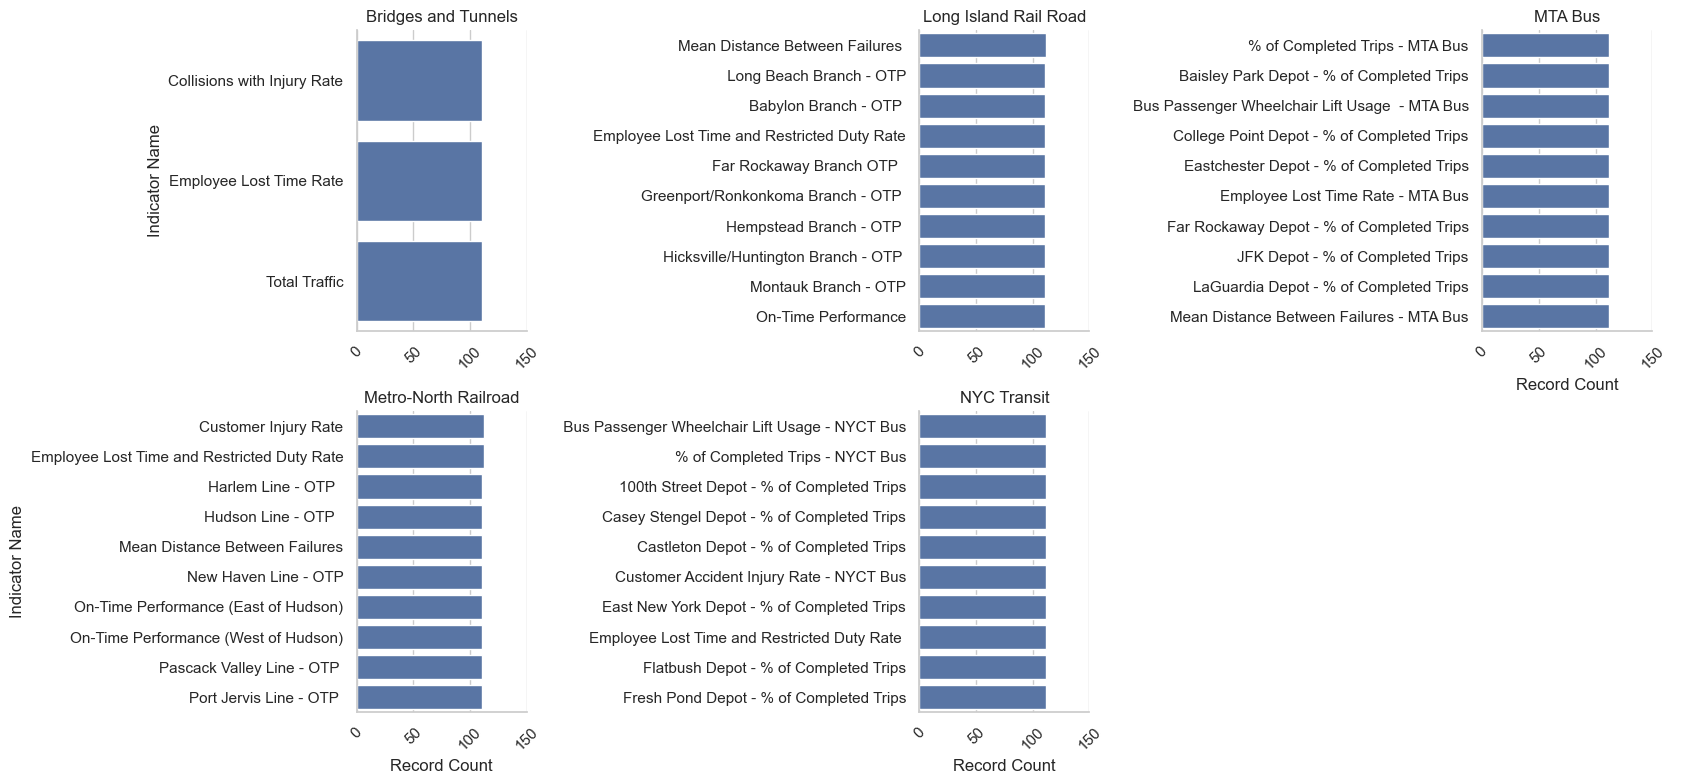

In [11]:
# Step 1: Count frequency of each indicator per agency
indicator_counts = df.groupby(['AGENCY_NAME', 'INDICATOR_NAME']).size().reset_index(name='Count')
# Step 2: Get top 5 indicators per agency
top5_per_agency = (
    indicator_counts.sort_values(['AGENCY_NAME', 'Count'], ascending=[True, False])
    .groupby('AGENCY_NAME')
    .head(10)
)
# Step 3: Faceted bar plot
g = sns.catplot(
    data=top5_per_agency,
    kind="bar",
    x="Count",
    y="INDICATOR_NAME",
    col="AGENCY_NAME",
    col_wrap=3,
    height=4,
    aspect=1.4,
    sharex=False,
    sharey=False
)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.set_ylabels("Indicator Name")
g.set_xlabels("Record Count")
plt.tight_layout()
plt.show()

# Correlation Matrix of Numerical Variables

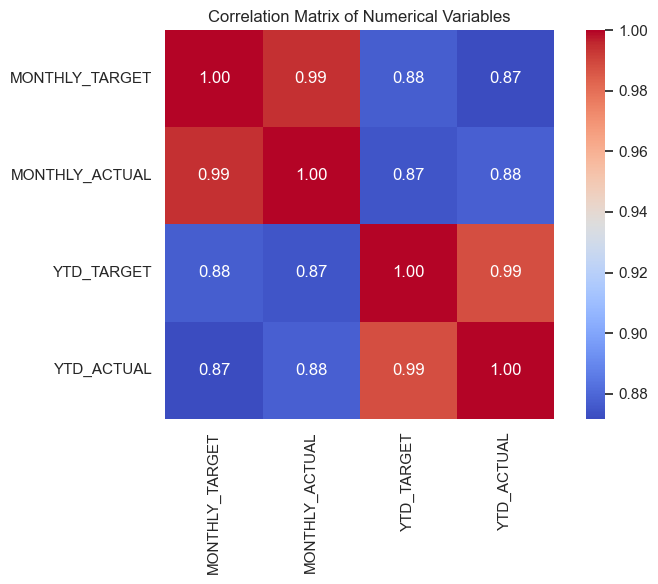

In [12]:
# Select only the numeric columns
numeric_cols = ['MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YTD_TARGET', 'YTD_ACTUAL']
df_numeric = df[numeric_cols]

# Calculate correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Faceted Boxplots Grouped by INDICATOR_UNIT

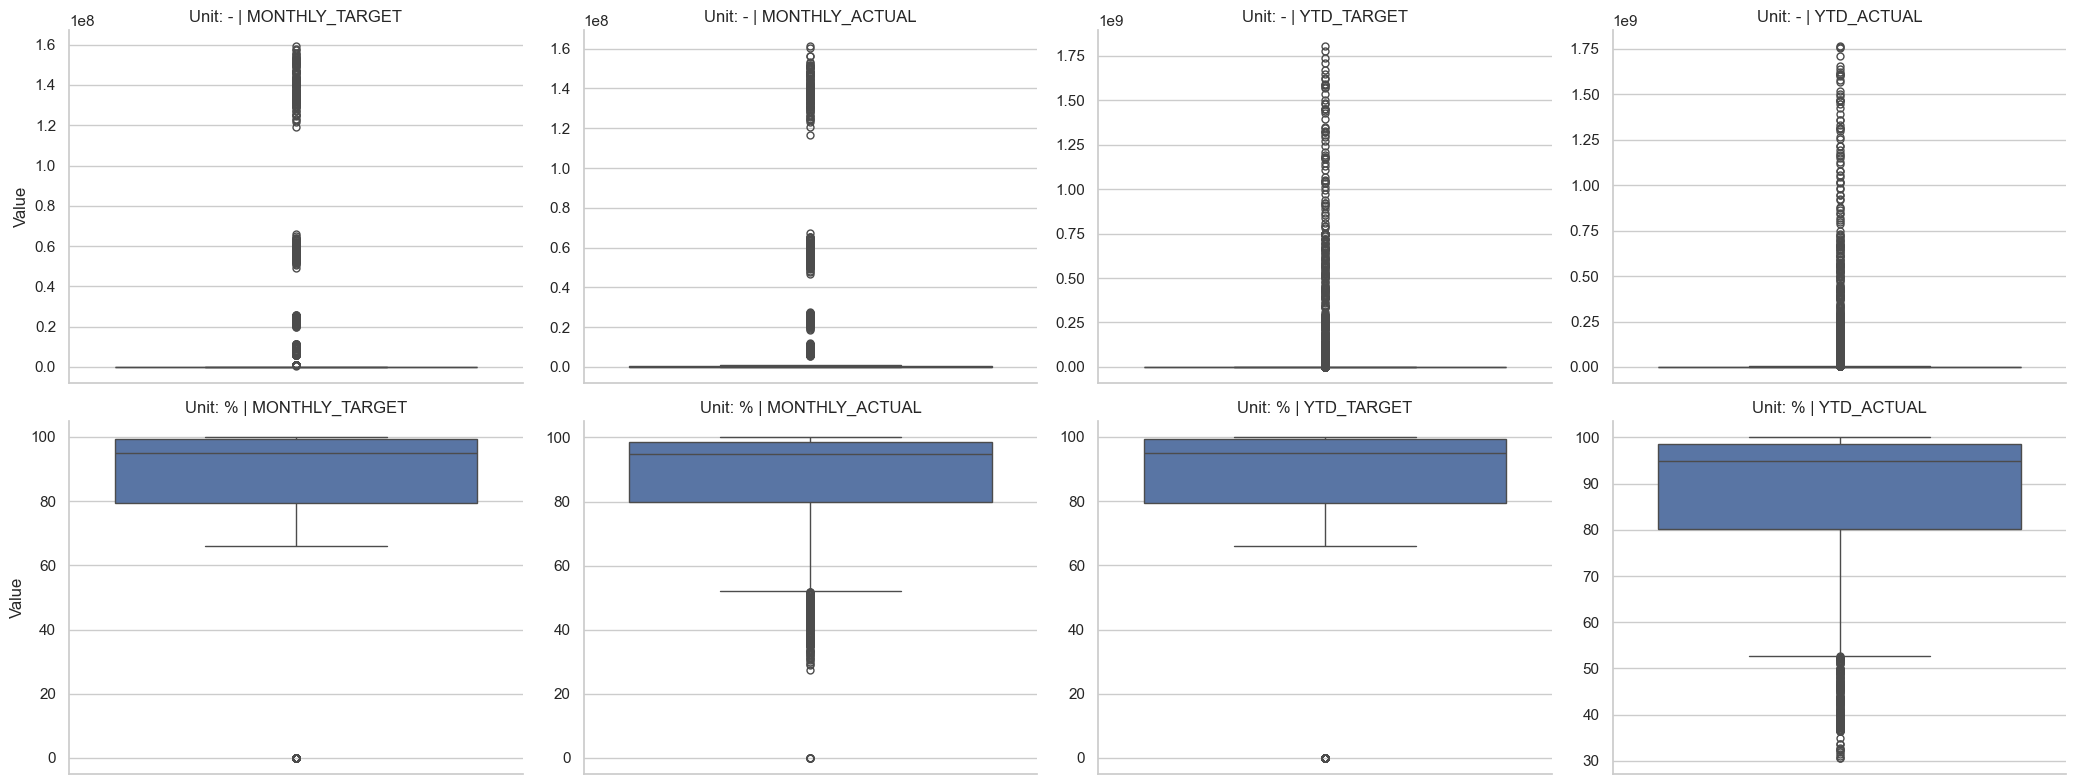

In [13]:
# Select numeric columns + unit column
numerical_cols = ['MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YTD_TARGET', 'YTD_ACTUAL']
melted_df = df[numerical_cols + ['INDICATOR_UNIT']].melt(
    id_vars='INDICATOR_UNIT',
    var_name='Metric',
    value_name='Value'
)

# Clean up blank units
melted_df['INDICATOR_UNIT'] = melted_df['INDICATOR_UNIT'].replace('', 'Unspecified')

# Create FacetGrid of boxplots (column = metric, row = indicator unit)
g = sns.catplot(
    data=melted_df,
    kind="box",
    y="Value",
    col="Metric",
    row="INDICATOR_UNIT",
    height=4,
    aspect=1.3,
    sharey=False
)

g.set_titles(col_template="{col_name}", row_template="Unit: {row_name}")
g.set_ylabels("Value")
plt.tight_layout()
plt.show()

## ----------- DATA PREPROCESSING STEPS -----------

In [14]:
import numpy as np

# Handling Zero Values


In [7]:
# Separate percentage and raw value indicators
percent_df = df[df['INDICATOR_UNIT'] == '%']
raw_df = df[df['INDICATOR_UNIT'] == '-']

# For percentage-based
zero_monthly_target_pct = (percent_df['MONTHLY_TARGET'] == 0).sum()
zero_ytd_target_pct = (percent_df['YTD_TARGET'] == 0).sum()
zero_either_pct = ((percent_df['MONTHLY_TARGET'] == 0) | (percent_df['YTD_TARGET'] == 0)).sum()
total_pct = len(percent_df)

# For raw-value-based
zero_monthly_target_raw = (raw_df['MONTHLY_TARGET'] == 0).sum()
zero_ytd_target_raw = (raw_df['YTD_TARGET'] == 0).sum()
zero_either_raw = ((raw_df['MONTHLY_TARGET'] == 0) | (raw_df['YTD_TARGET'] == 0)).sum()
total_raw = len(raw_df)

# Display results
print("=== Percentage-Based Indicators (%) ===")
print(f"Total rows: {total_pct}")
print(f"MONTHLY_TARGET = 0: {zero_monthly_target_pct}")
print(f"YTD_TARGET = 0: {zero_ytd_target_pct}")
print(f"Either target = 0: {zero_either_pct}")
print(f"Affected rows (%): {zero_either_pct / total_pct:.2%}")

print("\n=== Raw Value Indicators (-) ===")
print(f"Total rows: {total_raw}")
print(f"MONTHLY_TARGET = 0: {zero_monthly_target_raw}")
print(f"YTD_TARGET = 0: {zero_ytd_target_raw}")
print(f"Either target = 0: {zero_either_raw}")
print(f"Affected rows (%): {zero_either_raw / total_raw:.2%}")


=== Percentage-Based Indicators (%) ===
Total rows: 10769
MONTHLY_TARGET = 0: 817
YTD_TARGET = 0: 890
Either target = 0: 890
Affected rows (%): 8.26%

=== Raw Value Indicators (-) ===
Total rows: 3093
MONTHLY_TARGET = 0: 389
YTD_TARGET = 0: 389
Either target = 0: 389
Affected rows (%): 12.58%


Flagging the zero values for both (% and -) indicator_unit 

In [16]:
df['ZERO_TARGET_FLAG'] = (
    ((df['INDICATOR_UNIT'] == '%') | (df['INDICATOR_UNIT'] == '-')) &
    ((df['MONTHLY_TARGET'] == 0) | (df['YTD_TARGET'] == 0))
)

Imputing the zeros with median (% values) in MONTHLY_TARGET

In [17]:
# Calculate medians from % indicators where MONTHLY_TARGET is non-zero
percent_monthly_medians = (
    df[(df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['MONTHLY_TARGET']
    .median()
    .rename('PERCENT_MONTHLY_MEDIAN')
)

# Create imputed column
df['MONTHLY_TARGET_IMPUTED'] = df['MONTHLY_TARGET']

# Apply imputation to rows where target is 0
df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] == 0),
    'MONTHLY_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['MONTHLY_TARGET'] == 0), 'INDICATOR_NAME'
].map(percent_monthly_medians)


In [18]:
# Preview rows that had 0 values and were imputed
preview_imputed_monthly = df[
    (df['INDICATOR_UNIT'] == '%') &
    (df['MONTHLY_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'MONTHLY_TARGET', 'MONTHLY_TARGET_IMPUTED']]

preview_imputed_monthly

,AGENCY_NAME,INDICATOR_NAME,MONTHLY_TARGET,MONTHLY_TARGET_IMPUTED
555,Long Island Rail Road,On-Time Performance,0.00,95.10
556,Long Island Rail Road,On-Time Performance,0.00,95.10
557,Long Island Rail Road,On-Time Performance,0.00,95.10
558,Long Island Rail Road,On-Time Performance,0.00,95.10
559,Long Island Rail Road,On-Time Performance,0.00,95.10
...,...,...,...,...
13771,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13772,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13773,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13783,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80


Imputing the zeros with median (% values) in YTD_TARGET

In [19]:
# Calculate medians from % indicators where YTD_TARGET is non-zero
percent_ytd_medians = (
    df[(df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['YTD_TARGET']
    .median()
    .rename('PERCENT_YTD_MEDIAN')
)

# Create imputed column
df['YTD_TARGET_IMPUTED'] = df['YTD_TARGET']

# Impute zero values using median
df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] == 0),
    'YTD_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '%') & (df['YTD_TARGET'] == 0), 'INDICATOR_NAME'
].map(percent_ytd_medians)


In [20]:
# Preview rows where YTD_TARGET was 0 and imputation has been applied
preview_imputed_ytd = df[
    (df['INDICATOR_UNIT'] == '%') &
    (df['YTD_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'YTD_TARGET', 'YTD_TARGET_IMPUTED']]

preview_imputed_ytd

,AGENCY_NAME,INDICATOR_NAME,YTD_TARGET,YTD_TARGET_IMPUTED
555,Long Island Rail Road,On-Time Performance,0.00,95.10
556,Long Island Rail Road,On-Time Performance,0.00,95.10
557,Long Island Rail Road,On-Time Performance,0.00,95.10
558,Long Island Rail Road,On-Time Performance,0.00,95.10
559,Long Island Rail Road,On-Time Performance,0.00,95.10
...,...,...,...,...
13783,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13785,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13812,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80
13820,NYC Transit,Subway Wait Assessment - S Fkln,0.00,97.80


Imputing the zeros with median (- values) in YTD_TARGET

In [21]:
# Take YTD_TARGET medians only from raw-unit, non-zero rows
raw_medians = (
    df[(df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['YTD_TARGET']
    .median()
    .rename('RAW_YTD_IMPUTED_VALUE')
)

# Create column to hold imputed values
df['RAW_YTD_TARGET_IMPUTED'] = df['YTD_TARGET']

# Apply imputation only to rows with 0 values
df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] == 0),
    'RAW_YTD_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['YTD_TARGET'] == 0), 'INDICATOR_NAME'
].map(raw_medians)


In [22]:
# Preview rows where raw YTD_TARGET was 0 and has been imputed
preview_imputed_raw_ytd = df[
    (df['INDICATOR_UNIT'] == '-') &
    (df['YTD_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'YTD_TARGET', 'RAW_YTD_TARGET_IMPUTED']]

# Display first few rows
preview_imputed_raw_ytd


,AGENCY_NAME,INDICATOR_NAME,YTD_TARGET,RAW_YTD_TARGET_IMPUTED
84,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
85,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
86,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
87,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
88,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.85
...,...,...,...,...
9179,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9180,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9181,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"
9182,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"665,039.00"


Imputing the zeros with median (- values) in MONTHLY_TARGET

In [23]:
# Take MONTHLY_TARGET medians only from raw-unit, non-zero rows
monthly_raw_medians = (
    df[(df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] != 0)]
    .groupby('INDICATOR_NAME')['MONTHLY_TARGET']
    .median()
    .rename('RAW_MONTHLY_IMPUTED_VALUE')
)

# Create column to hold imputed values
df['RAW_MONTHLY_TARGET_IMPUTED'] = df['MONTHLY_TARGET']

# Apply imputation only to rows with 0 values
df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] == 0),
    'RAW_MONTHLY_TARGET_IMPUTED'
] = df.loc[
    (df['INDICATOR_UNIT'] == '-') & (df['MONTHLY_TARGET'] == 0), 'INDICATOR_NAME'
].map(monthly_raw_medians)


In [24]:
# Preview rows where raw YTD_TARGET was 0 and has been imputed
preview_imputed_raw_monthly = df[
    (df['INDICATOR_UNIT'] == '-') &
    (df['MONTHLY_TARGET'] == 0)
][['AGENCY_NAME', 'INDICATOR_NAME', 'MONTHLY_TARGET', 'RAW_MONTHLY_TARGET_IMPUTED']]

preview_imputed_raw_monthly

,AGENCY_NAME,INDICATOR_NAME,MONTHLY_TARGET,RAW_MONTHLY_TARGET_IMPUTED
84,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
85,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
86,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
87,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
88,Bridges and Tunnels,Collisions with Injury Rate,0.00,0.89
...,...,...,...,...
9179,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9180,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9181,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"
9182,NYC Transit,Bus Passenger Wheelchair Lift Usage - NYCT Bus,0.00,"119,629.00"


TEST

In [25]:
# For RAW YTD target
raw_ytd_summary = (
    df[df['INDICATOR_UNIT'] == '-']
    .groupby('INDICATOR_NAME')
    .agg(
        original_median=('YTD_TARGET', lambda x: x[x != 0].median()),
        imputed_value=('YTD_TARGET', lambda x: x[x != 0].median())  # NOT from the imputed column
    )
    .reset_index()
)

# View top rows
raw_ytd_summary


,INDICATOR_NAME,original_median,imputed_value
0,Bus Passenger Wheelchair Lift Usage - NYCT Bus,"665,039.00","665,039.00"
1,Bus Passenger Wheelchair Lift Usage - MTA Bus,"26,583.00","26,583.00"
2,Collisions with Injury Rate,0.85,0.85
3,Collisions with Injury Rate - MTA Bus,5.25,5.25
4,Collisions with Injury Rate - NYCT Bus,6.44,6.44
5,Customer Accident Injury Rate - MTA Bus,1.27,1.27
6,Customer Accident Injury Rate - NYCT Bus,1.11,1.11
7,Customer Injury Rate,2.80,2.80
8,Customer Injury Rate - Subways,3.00,3.00
9,Employee Lost Time Rate,4.10,4.10


# Removing Outliers

In [ ]:
# Step 1: Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Step 2: Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  # log(1 + x) avoids log(0) issues

# Preview transformed data
df_raw[[col for col in df_raw.columns if col.startswith('LOG_')]]


,LOG_MONTHLY_ACTUAL,LOG_MONTHLY_TARGET,LOG_YTD_ACTUAL,LOG_YTD_TARGET
0,0.43,0.56,0.43,0.56
1,0.68,0.70,0.56,0.64
2,0.59,0.65,0.57,0.64
3,0.61,0.79,0.58,0.68
4,0.91,0.73,0.66,0.69
...,...,...,...,...
9243,11.67,11.72,14.22,14.19
9244,11.56,11.44,11.56,11.44
9245,11.50,11.38,12.22,12.11
9246,11.55,11.65,12.64,12.60


# Dropping low worth/variance columns

In [28]:
# Find columns with a single unique value
low_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
print("Low-variance columns:", low_variance_cols)


Low-variance columns: ['FREQUENCY']


In [ ]:
# Dropping the low variance columns
df = df.drop(columns=low_variance_cols)
print(df.columns)

Index(['INDICATOR_SEQ', 'PARENT_SEQ', 'AGENCY_NAME', 'INDICATOR_NAME',
       'DESCRIPTION', 'CATEGORY', 'DESIRED_CHANGE', 'INDICATOR_UNIT',
       'DECIMAL_PLACES', 'PERIOD_YEAR', 'PERIOD_MONTH', 'YTD_TARGET',
       'YTD_ACTUAL', 'MONTHLY_TARGET', 'MONTHLY_ACTUAL', 'YYYY_MM', 'DATE',
       'ZERO_TARGET_FLAG', 'MONTHLY_TARGET_IMPUTED', 'YTD_TARGET_IMPUTED',
       'RAW_YTD_TARGET_IMPUTED', 'RAW_MONTHLY_TARGET_IMPUTED'],
      dtype='object')


# EDA 2nd round


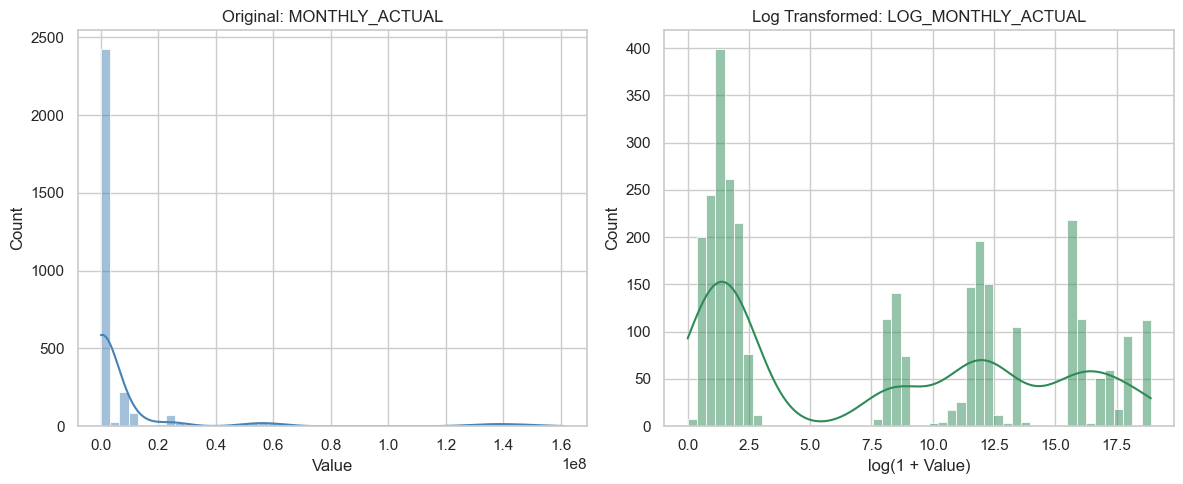

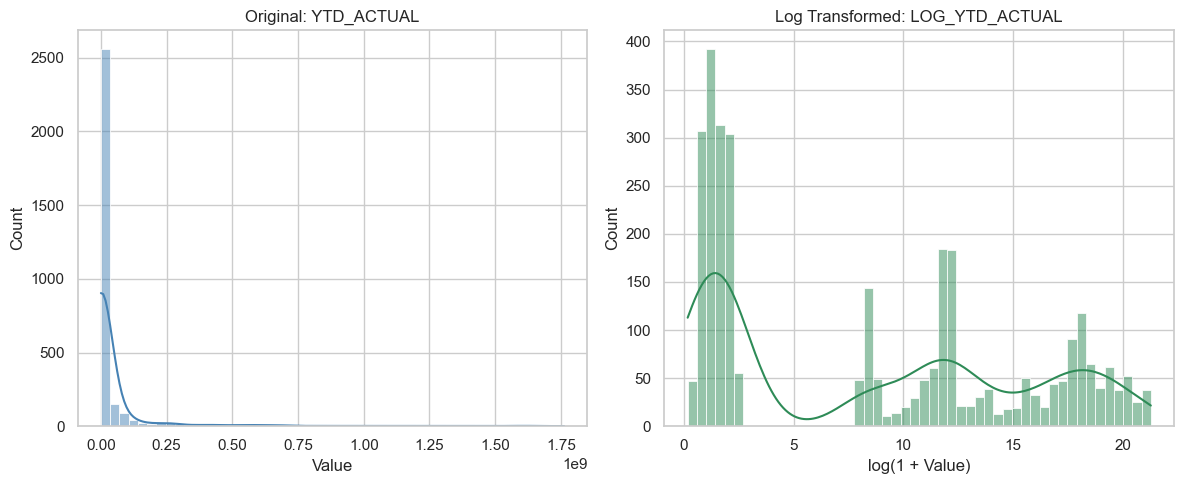

In [33]:
# List of original columns and their log-transformed counterparts
numeric_cols = ['MONTHLY_ACTUAL', 'YTD_ACTUAL', 'RAW_MONTHLY_TARGET_IMPUTED', 'RAW_YTD_TARGET_IMPUTED']

for col in numeric_cols:
    log_col = f'LOG_{col}'
    
    # Check if log-transformed column exists to avoid errors
    if log_col in df_raw.columns:
        plt.figure(figsize=(12, 5))
        
        # Original
        plt.subplot(1, 2, 1)
        sns.histplot(df_raw[col], bins=50, kde=True, color='steelblue')
        plt.title(f'Original: {col}')
        plt.xlabel('Value')
        
        # Log-transformed
        plt.subplot(1, 2, 2)
        sns.histplot(df_raw[log_col], bins=50, kde=True, color='seagreen')
        plt.title(f'Log Transformed: {log_col}')
        plt.xlabel('log(1 + Value)')
        
        plt.tight_layout()
        plt.show()

   LOG_MONTHLY_ACTUAL  LOG_MONTHLY_TARGET  LOG_YTD_ACTUAL  LOG_YTD_TARGET
0                0.43                0.56            0.43            0.56
1                0.68                0.70            0.56            0.64
2                0.59                0.65            0.57            0.64
3                0.61                0.79            0.58            0.68
4                0.91                0.73            0.66            0.69


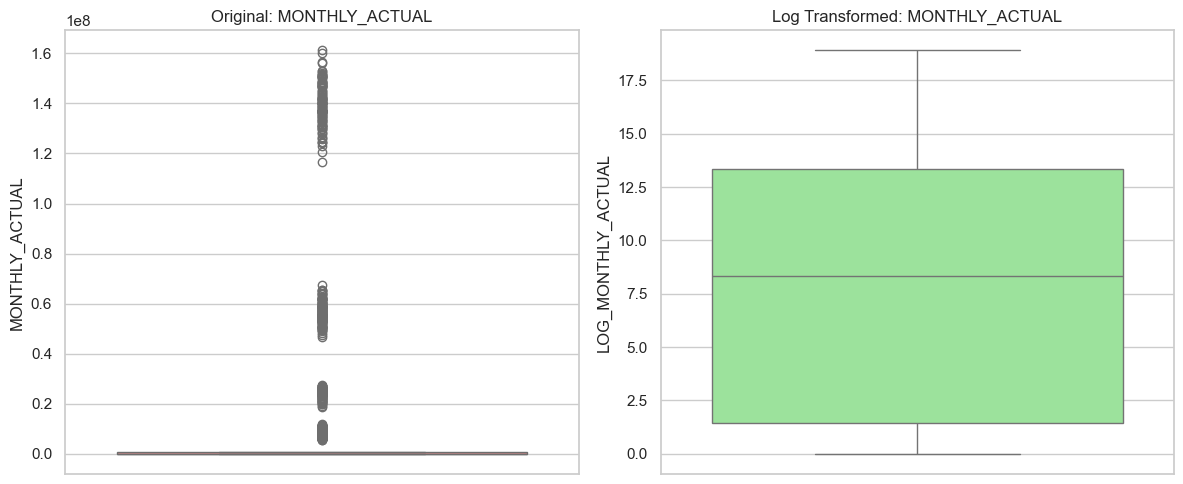

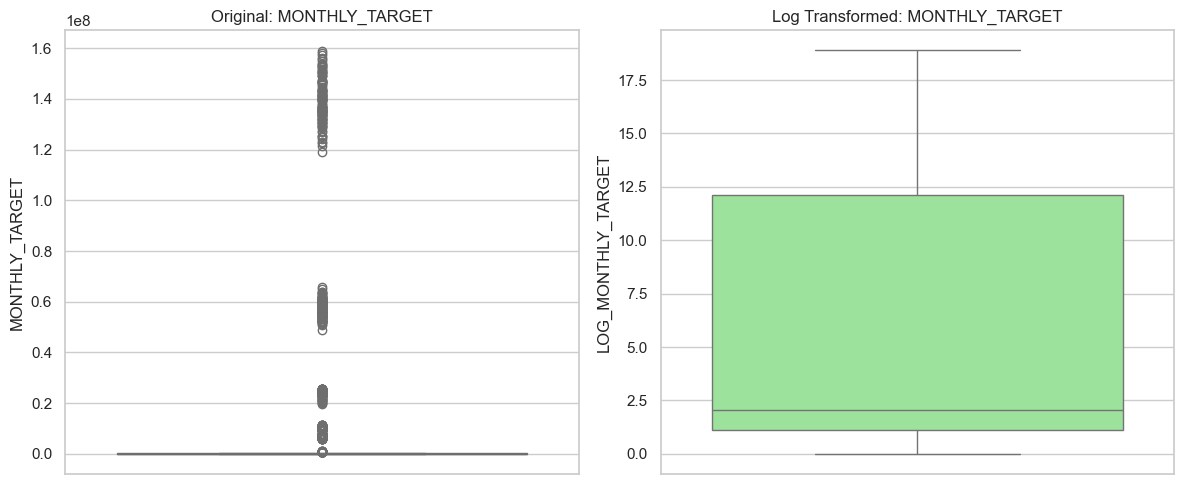

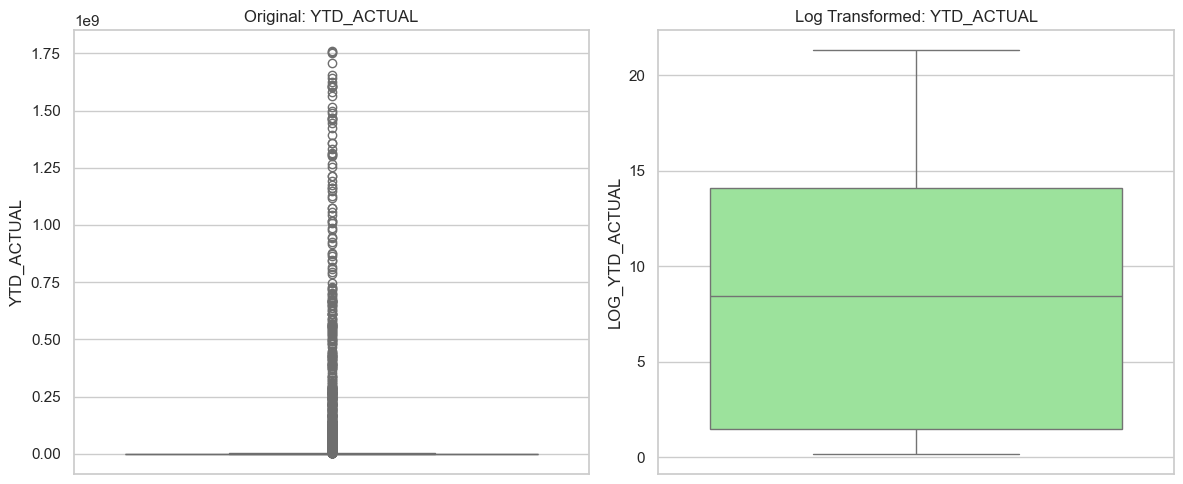

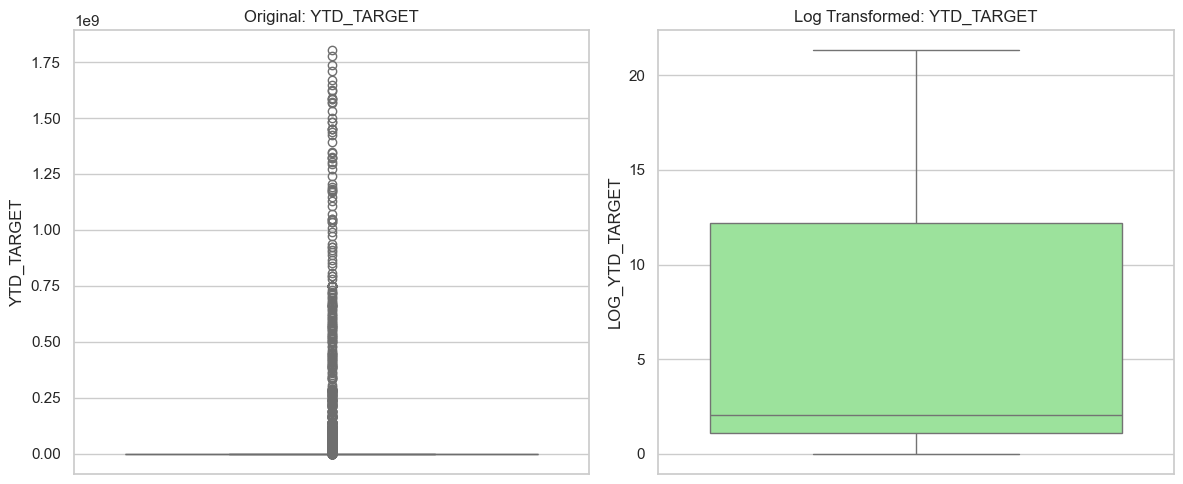

In [43]:
# Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  

# Preview transformed data
print(df_raw[[col for col in df_raw.columns if col.startswith('LOG_')]].head())

# Visualize before and after log transformation
for original_col in numeric_cols:
    log_col = f'LOG_{original_col}'
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_raw[original_col], color='lightcoral')
    plt.title(f'Original: {original_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_raw[log_col], color='lightgreen')
    plt.title(f'Log Transformed: {original_col}')

    plt.tight_layout()
    plt.show()

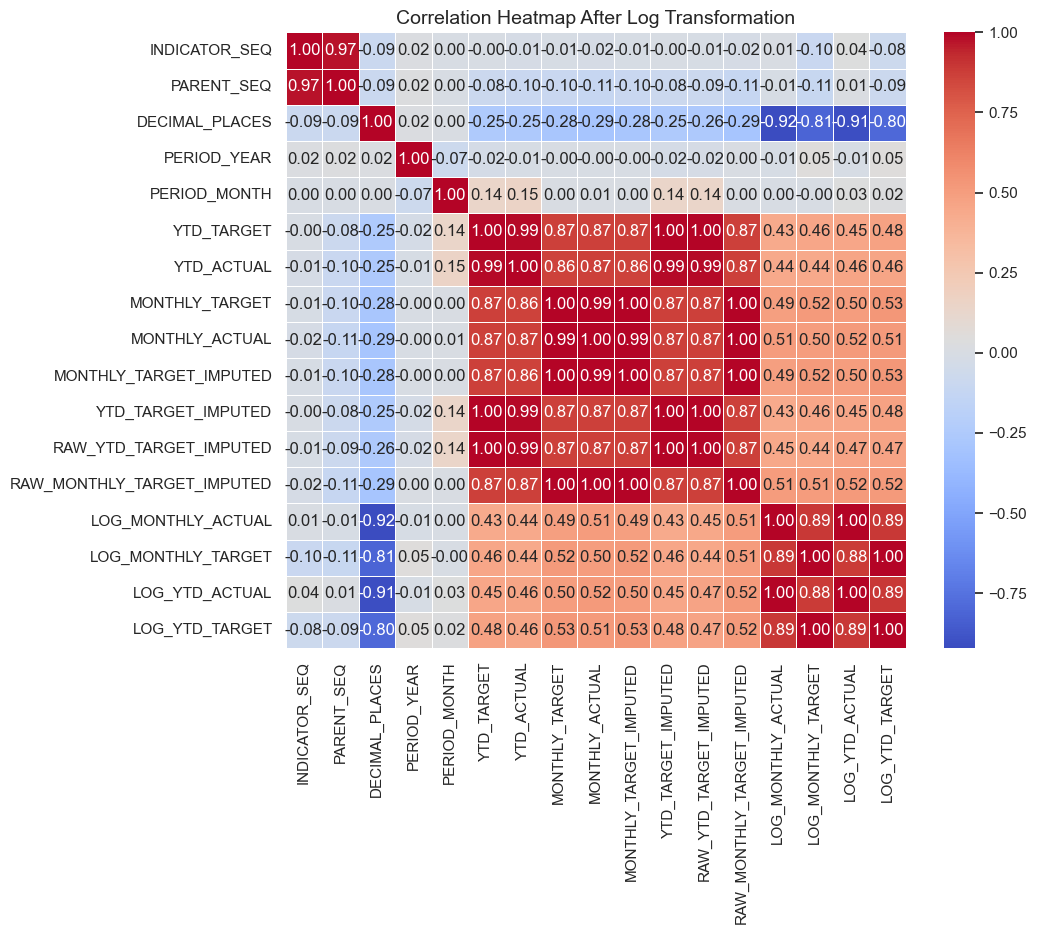

In [ ]:
# Filter only raw unit rows (INDICATOR_UNIT = '-')
df_raw = df[df['INDICATOR_UNIT'] == '-'].copy()

# Apply log1p transformation to numerical columns
numeric_cols = ['MONTHLY_ACTUAL', 'MONTHLY_TARGET', 'YTD_ACTUAL', 'YTD_TARGET']
for col in numeric_cols:
    df_raw[f'LOG_{col}'] = np.log1p(df_raw[col])  # log(1 + x) avoids log(0) issues

# Calculate the correlation matrix for numerical columns in df_raw
corr = df_raw.select_dtypes(include=np.number).corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap After Log Transformation", fontsize=14)
plt.show()

# Temporal Patterns Analysis

Dataset Time Range:
Start: 2008-01-01 00:00:00
End: 2017-04-01 00:00:00
Total months: 112


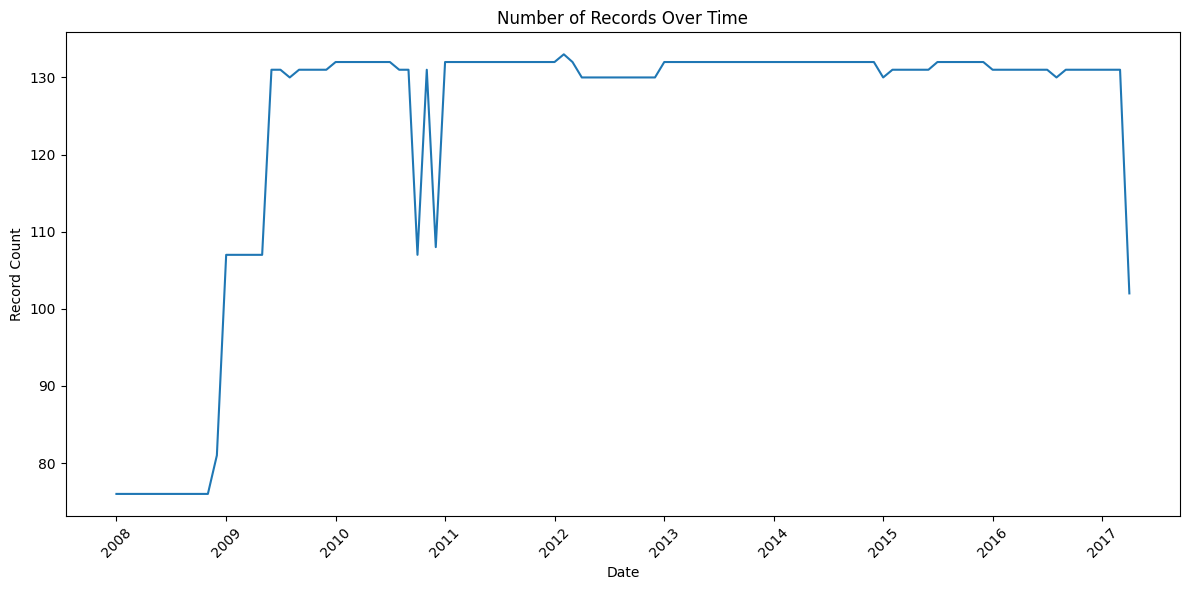

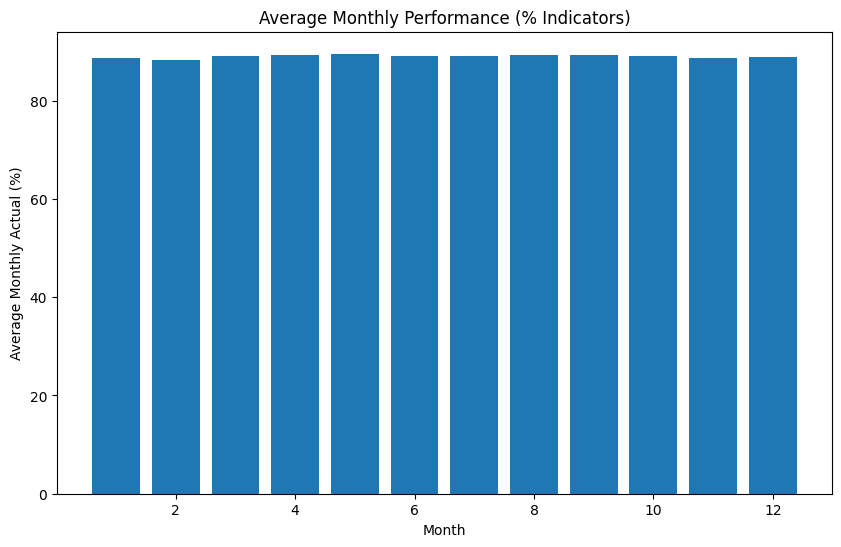

In [9]:
# Analyze temporal patterns in the data
print("Dataset Time Range:")
print(f"Start: {df['DATE'].min()}")
print(f"End: {df['DATE'].max()}")
print(f"Total months: {df['DATE'].nunique()}")

# Check data distribution over time
plt.figure(figsize=(12, 6))
monthly_counts = df.groupby('DATE').size()
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Number of Records Over Time')
plt.xlabel('Date')
plt.ylabel('Record Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for seasonality in performance metrics
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month

# Sample seasonal analysis for percentage indicators
pct_data = df[df['INDICATOR_UNIT'] == '%']
seasonal_perf = pct_data.groupby('Month')['MONTHLY_ACTUAL'].mean()

plt.figure(figsize=(10, 6))
plt.bar(seasonal_perf.index, seasonal_perf.values)
plt.title('Average Monthly Performance (% Indicators)')
plt.xlabel('Month')
plt.ylabel('Average Monthly Actual (%)')
plt.show()

# Key EDA Insights Summary

Based on the exploratory analysis above, here are the key findings:

## Data Structure
- **13,862 total records** spanning 9+ years (2008-2017)
- **5 MTA agencies** with NYC Transit dominating (60%+ of records)
- **Mixed indicator types**: Percentage-based (78%) vs Raw counts (22%)

## Data Quality Issues Identified
- **Zero target values**: 8.26% of percentage indicators, 12.58% of raw indicators
- **Scale heterogeneity**: Values range from 0-100% to millions (ridership)
- **Temporal consistency**: Steady reporting from 2009 onwards

## Key Patterns
- **Agency dominance**: NYC Transit has 6x more records than other agencies
- **Performance stability**: Most percentage indicators cluster around 90-95%
- **Seasonal consistency**: Minimal monthly variation in performance averages
- **Outlier presence**: Log transformation needed for raw value indicators

## Preprocessing Implications
- Median imputation strategy appropriate for zero targets
- Log transformation essential for raw value normalization
- Temporal features (lag, rolling) justified by time series nature
- Cross-agency modeling feasible due to consistent reporting